February: Ideal cases - Salinity cross-shore cross-sections with isohalines.

In [5]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [6]:
def get_vars_cross(dirname, x_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y = slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        vosaline0 = dsT.variables['vosaline'][:, :, y, x_ind]
        deptht = dsT.variables['deptht'][:]
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :, y, x_ind]
        
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, tmask, deptht

In [7]:
def get_1day_avg(sal, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    sal_day = np.mean(sal[day, ...], axis=0)
    return sal_day

In [65]:
class MpNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, mp=None, clip=False):
        self.mp = mp
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.mp, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [98]:
def plot_iso(vosaline_daily_ma, deptht, vmin, vmax, norm, levels):
    xs = np.arange(vosaline_daily_ma.shape[-1])
    cmap = plt.get_cmap(cm.Spectral_r)
    cmap.set_bad('wheat')
    fig, axes = plt.subplots(6, 2, figsize = (20, 40))
    for ax, n in zip(axes.flatten(), np.arange(12)): 
        plot_array = vosaline_daily_ma[n, :, :]
        p = ax.pcolormesh(xs, deptht, plot_array, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
        if levels == None:
            pass
        else:
            cs = ax.contour(xs, deptht, plot_array, colors = 'k', alpha=0.1, levels=levels)
        ax.set_ylim([deptht.max(), 0])
        ax.set_xlim([0, xs[-1]])
        ax.set_title('Day: ' + str(n+1) + ', max salinity = ' + str(plot_array.max()))
        fig.colorbar(p, ax=ax)
    return fig

# Salinity reference profile

In [9]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

In [10]:
levels = np.sort(vosaline_ref_profile[:])[::2]

In [11]:
levels

array([ 22.19425201,  28.71079445,  29.93310547,  30.72694397,
        31.60148811,  32.28652573,  32.85224915,  33.4180603 ,
        33.74547577,  34.02747345,  34.2559967 ,  34.4551506 ,
        34.56965637,  34.67427826,  34.75435638,  34.82886505,
        34.86204147,  34.8960762 ,  34.91975784,  34.93091965,
        34.94955063,  34.96502686,  34.96596527,  34.9757843 ,
        34.97871399,  34.98160172,  34.98871613,  34.99358368,
        34.99643707,  34.99744034,  35.00040817,  35.00831985,
        35.01628494,  35.02328873,  35.02941513,  35.03532028,
        35.04141617,  35.04759598,  35.05363846,  35.06093216], dtype=float32)

# X index

In [12]:
x_ind = 130

# Ideal_half

In [13]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_half_flt/'
vosaline, tmask, deptht = get_vars_cross(dirname, x_ind)

vosaline_daily = np.full((vosaline.shape[-3]/24, vosaline.shape[-2], vosaline.shape[-1]), np.nan)

for i in range(vosaline_daily.shape[0]):
    day_start, day_end = i, i+1
    vosaline_daily[i, :, :] = get_1day_avg(vosaline, day_start, day_end)

tmask_cross = np.tile(tmask[0, 0, :, :], (vosaline_daily.shape[0], 1, 1))

vosaline_daily_ma = np.ma.array(vosaline_daily, mask = 1 - tmask_cross)

In [108]:
deptht[21], vosaline_ref_profile[9], vosaline_ref_profile[19], vosaline_ref_profile[20]

(188.125, 31.992544, 34.168858, 34.255997)

    day 1, ind 10, dep 91.875, max salinity 32.3599777222
    day 2, ind 17, dep 153.125, max salinity 33.8990071615
    day 3, ind 19, dep 170.625, max salinity 34.2004597982
    day 4, ind 19, dep 170.625, max salinity 34.1512756348
    day 5, ind 19, dep 170.625, max salinity 34.1382039388
    day 6, ind 19, dep 170.625, max salinity 34.1899871826
    day 7, ind 19, dep 170.625, max salinity 34.2044550578
    day 8, ind 19, dep 170.625, max salinity 34.1931152344
    day 9, ind 19, dep 170.625, max salinity 34.1937383016
    day 10, ind 20, dep 179.375, max salinity 34.2186940511
    day 11, ind 20, dep 179.375, max salinity 34.2527516683
    day 12, ind 20, dep 179.375, max salinity 34.2846984863
    day 13, ind 21, dep 188.125, max salinity 34.3295135498



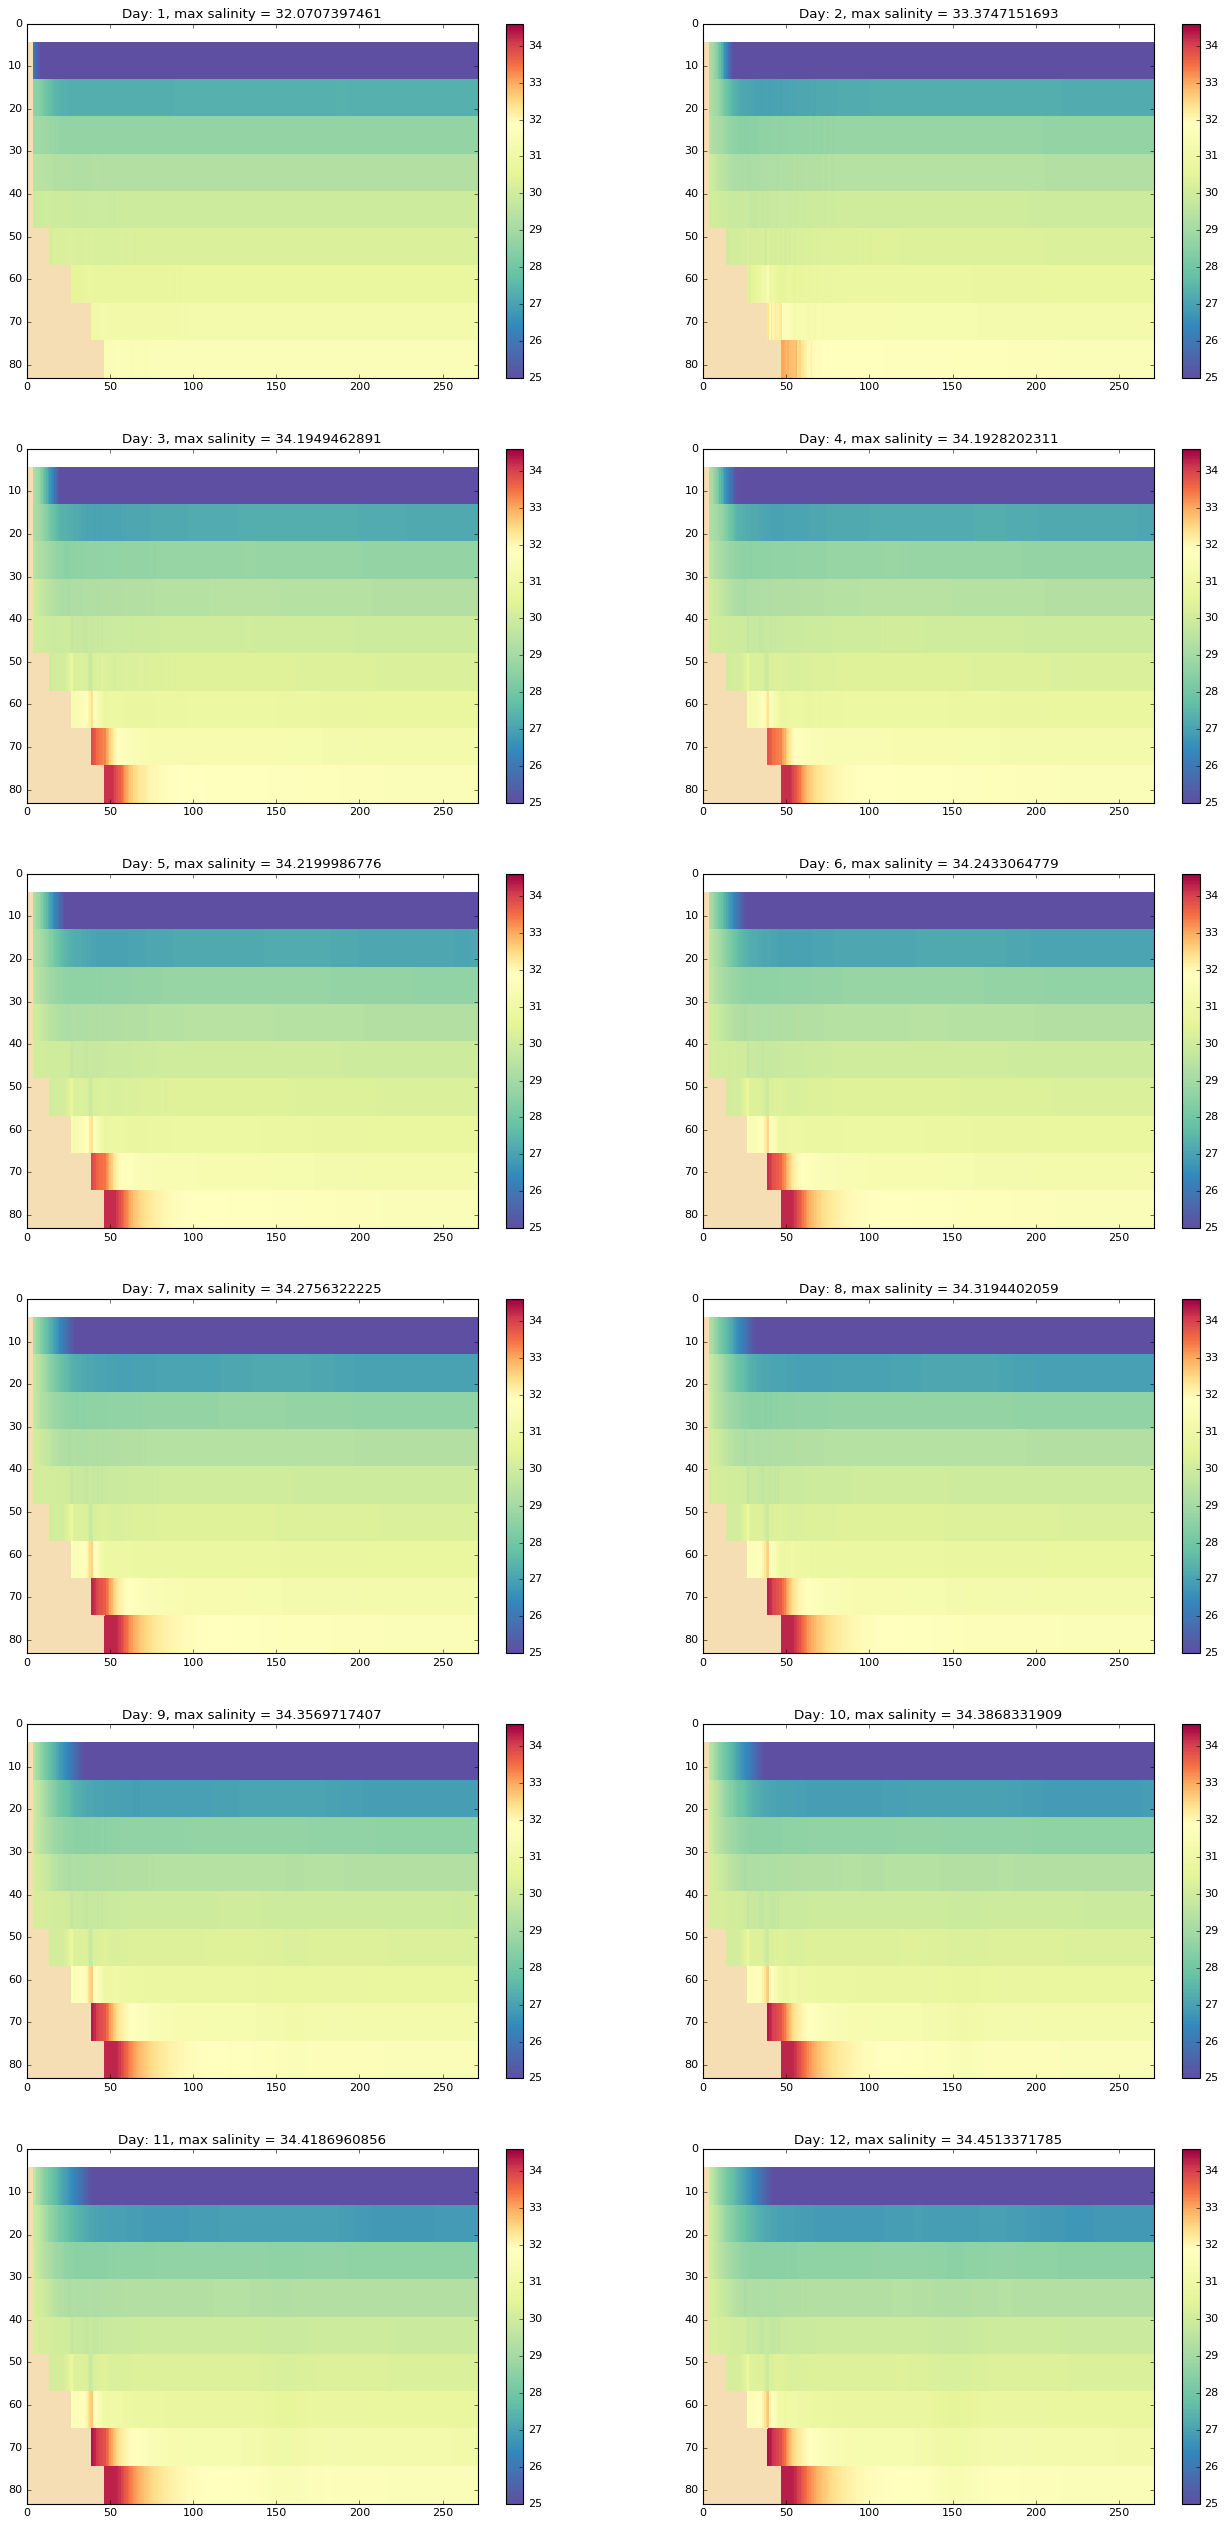

In [102]:
fig = plot_iso(vosaline_daily_ma[:, :10, :], deptht[:10], 25, 34.6, MpNormalize(mp=31.9), None)

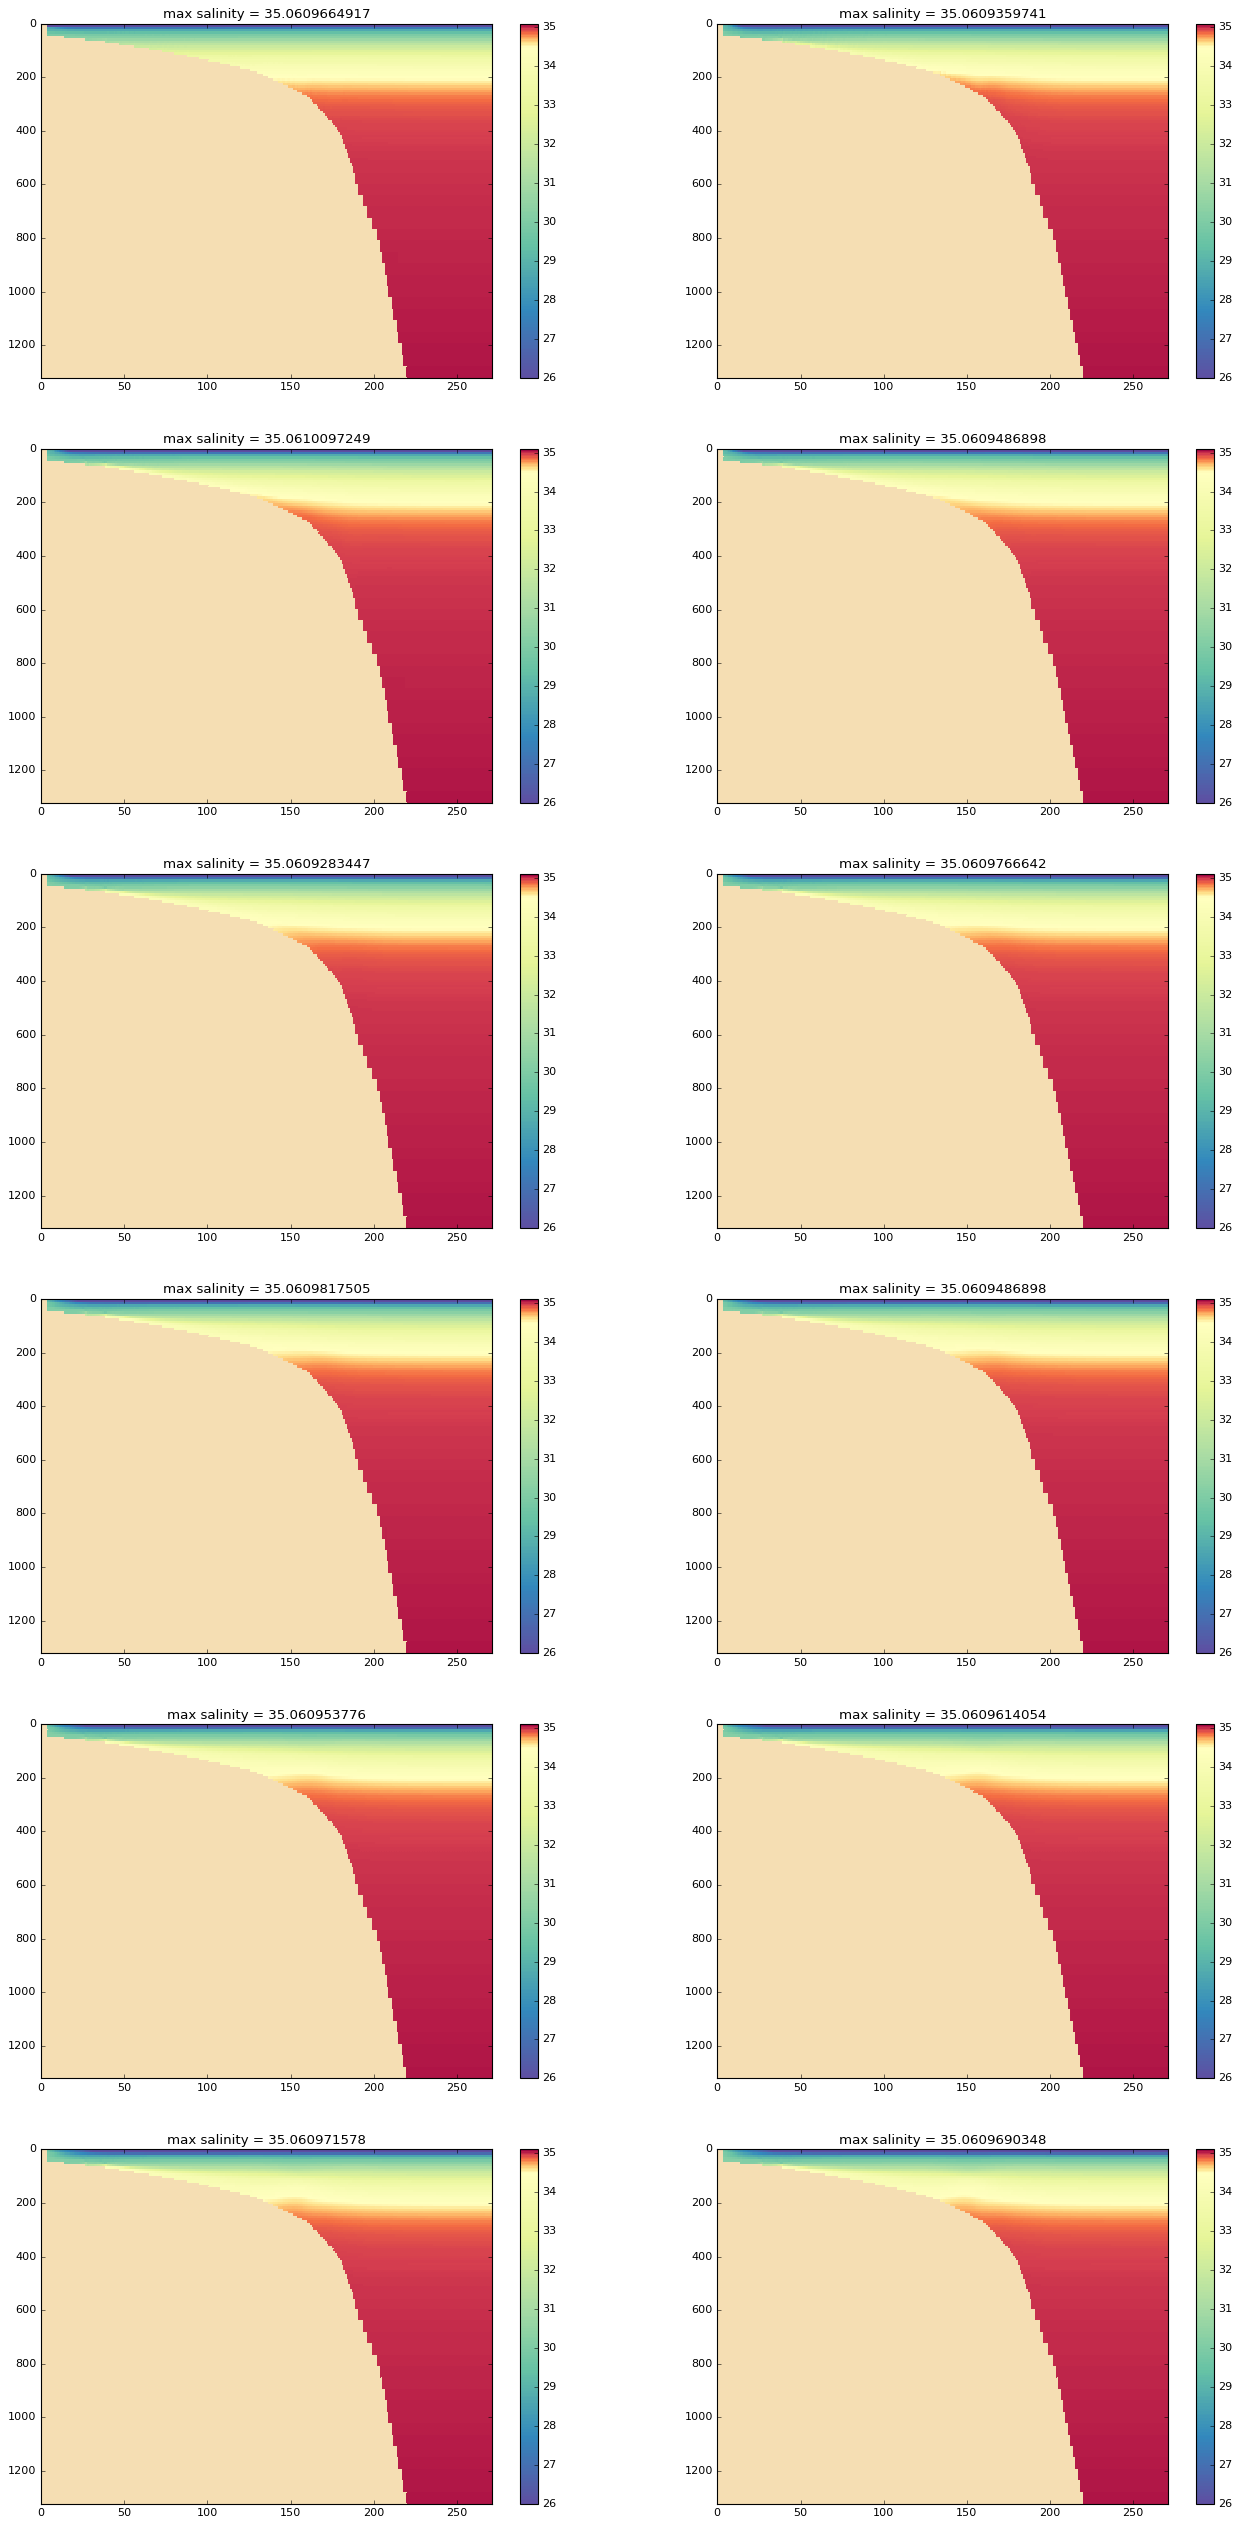

In [70]:
fig = plot_iso(vosaline_daily_ma, deptht, 26, 35.1, MpNormalize(mp=34.5), None)

# Ideal _base

In [103]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_flt/'
vosaline, tmask, deptht = get_vars_cross(dirname, x_ind)

vosaline_daily = np.full((vosaline.shape[-3]/24, vosaline.shape[-2], vosaline.shape[-1]), np.nan)

for i in range(vosaline_daily.shape[0]):
    day_start, day_end = i, i+1
    vosaline_daily[i, :, :] = get_1day_avg(vosaline, day_start, day_end)

tmask_cross = np.tile(tmask[0, 0, :, :], (vosaline_daily.shape[0], 1, 1))

vosaline_daily_ma = np.ma.array(vosaline_daily, mask = 1 - tmask_cross)

In [109]:
deptht[21], vosaline_ref_profile[9], vosaline_ref_profile[79]

(188.125, 31.992544, 35.062885)

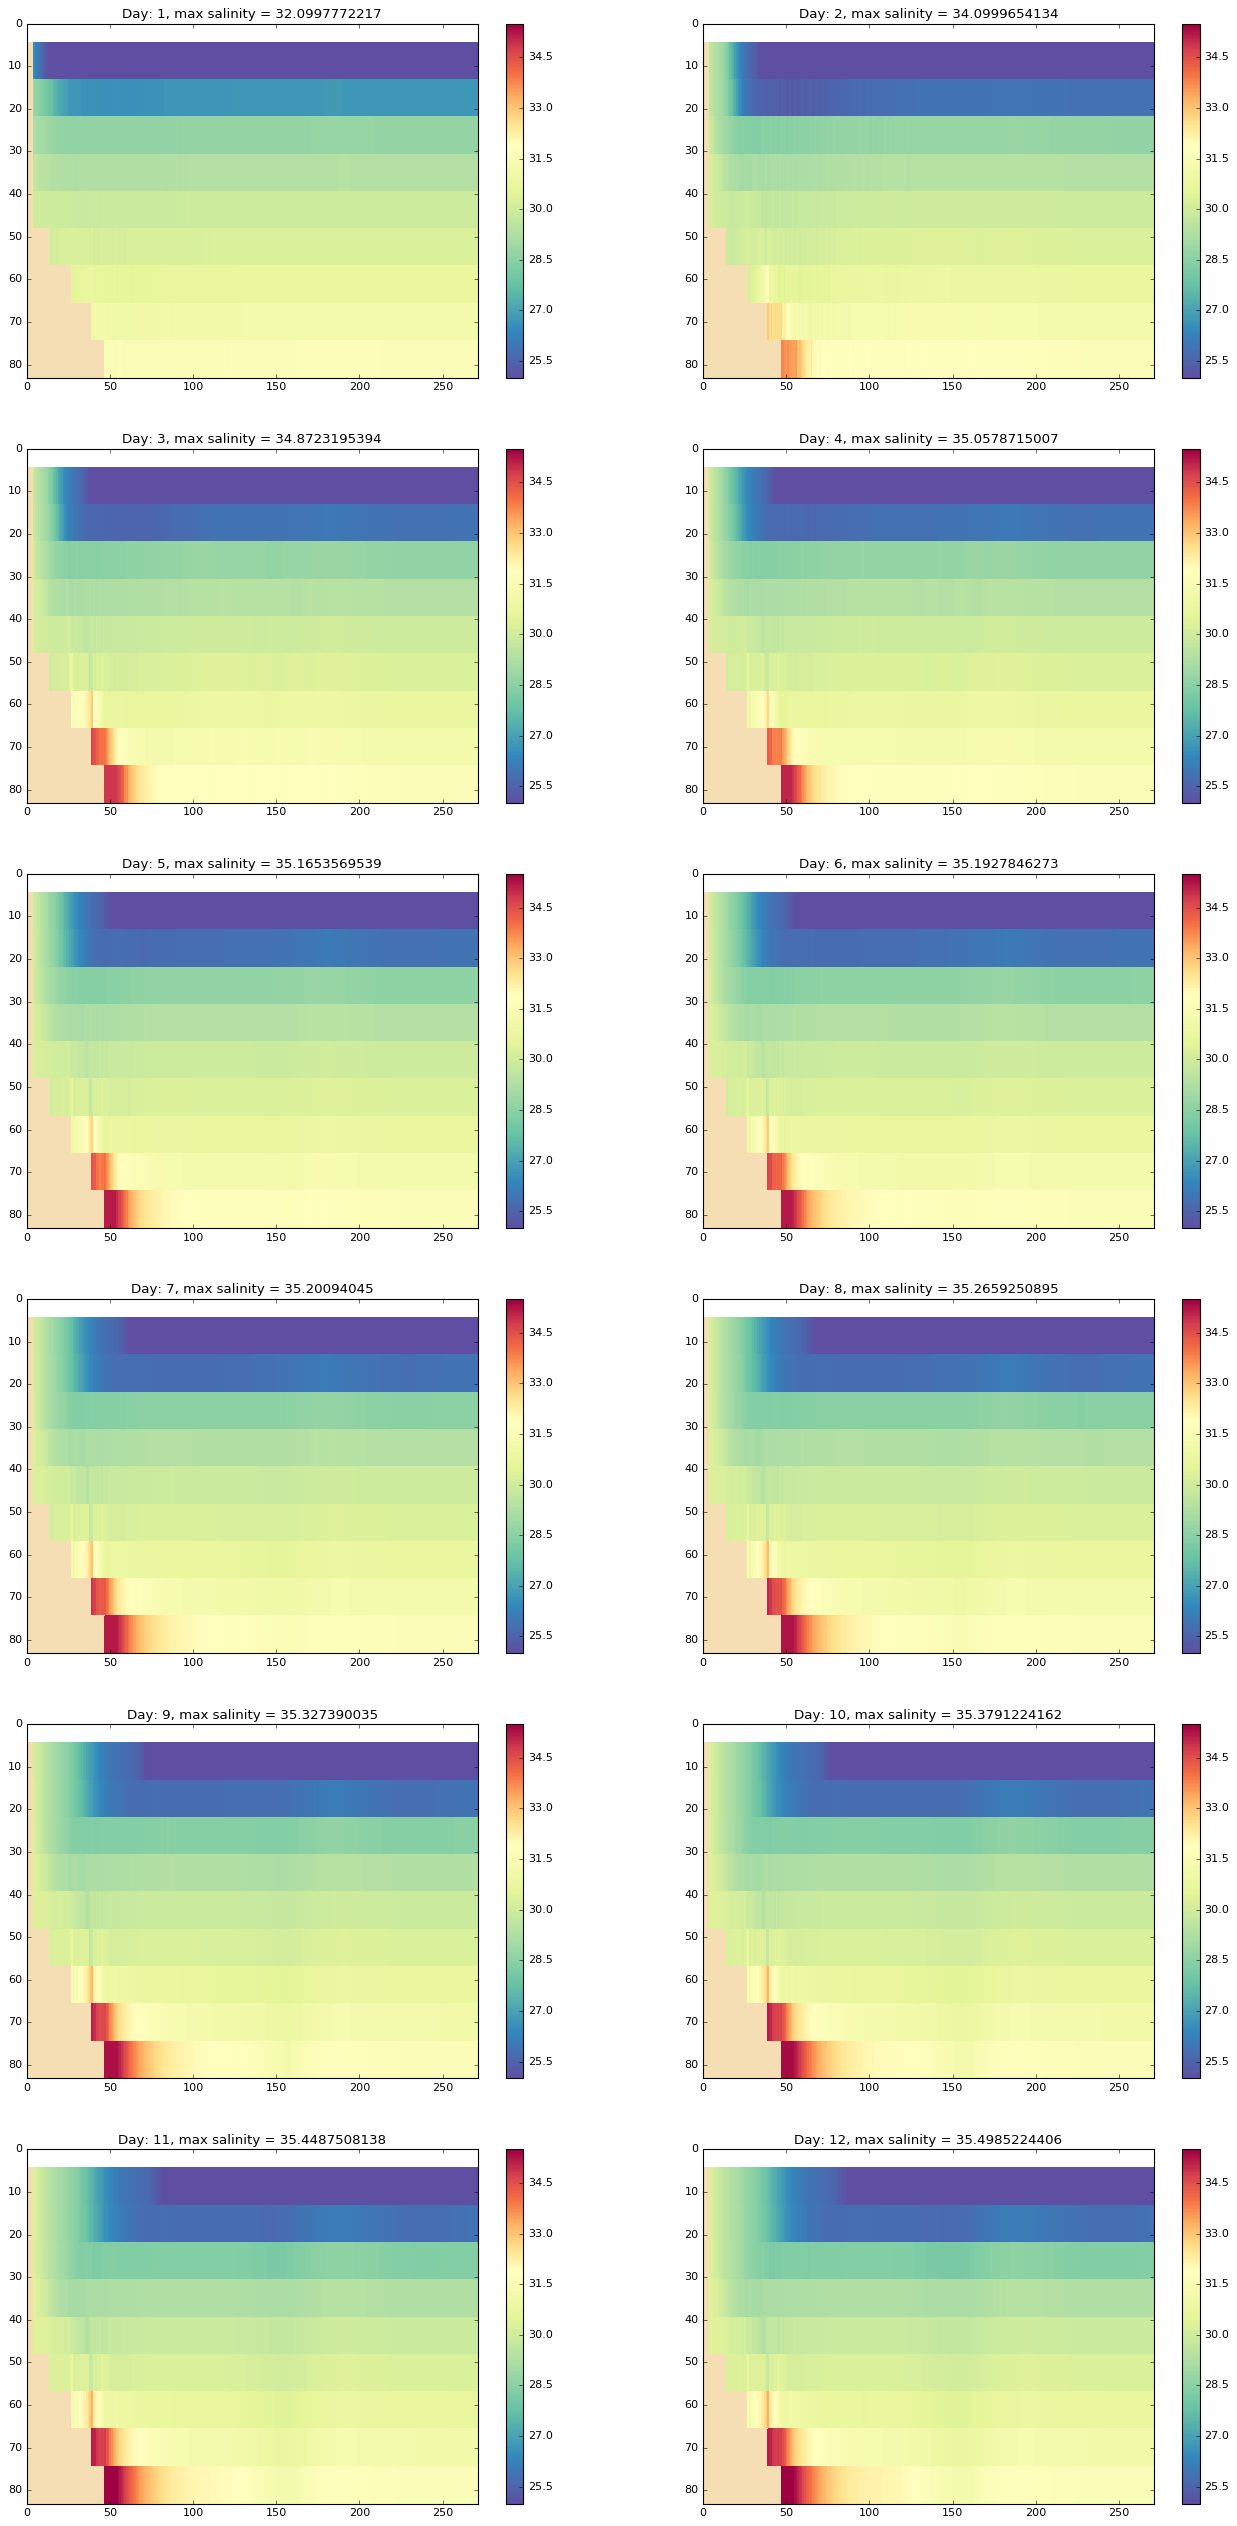

In [107]:
fig = plot_iso(vosaline_daily_ma[:, :10, :], deptht[:10], 25, 35.5, MpNormalize(mp=31.9), None)

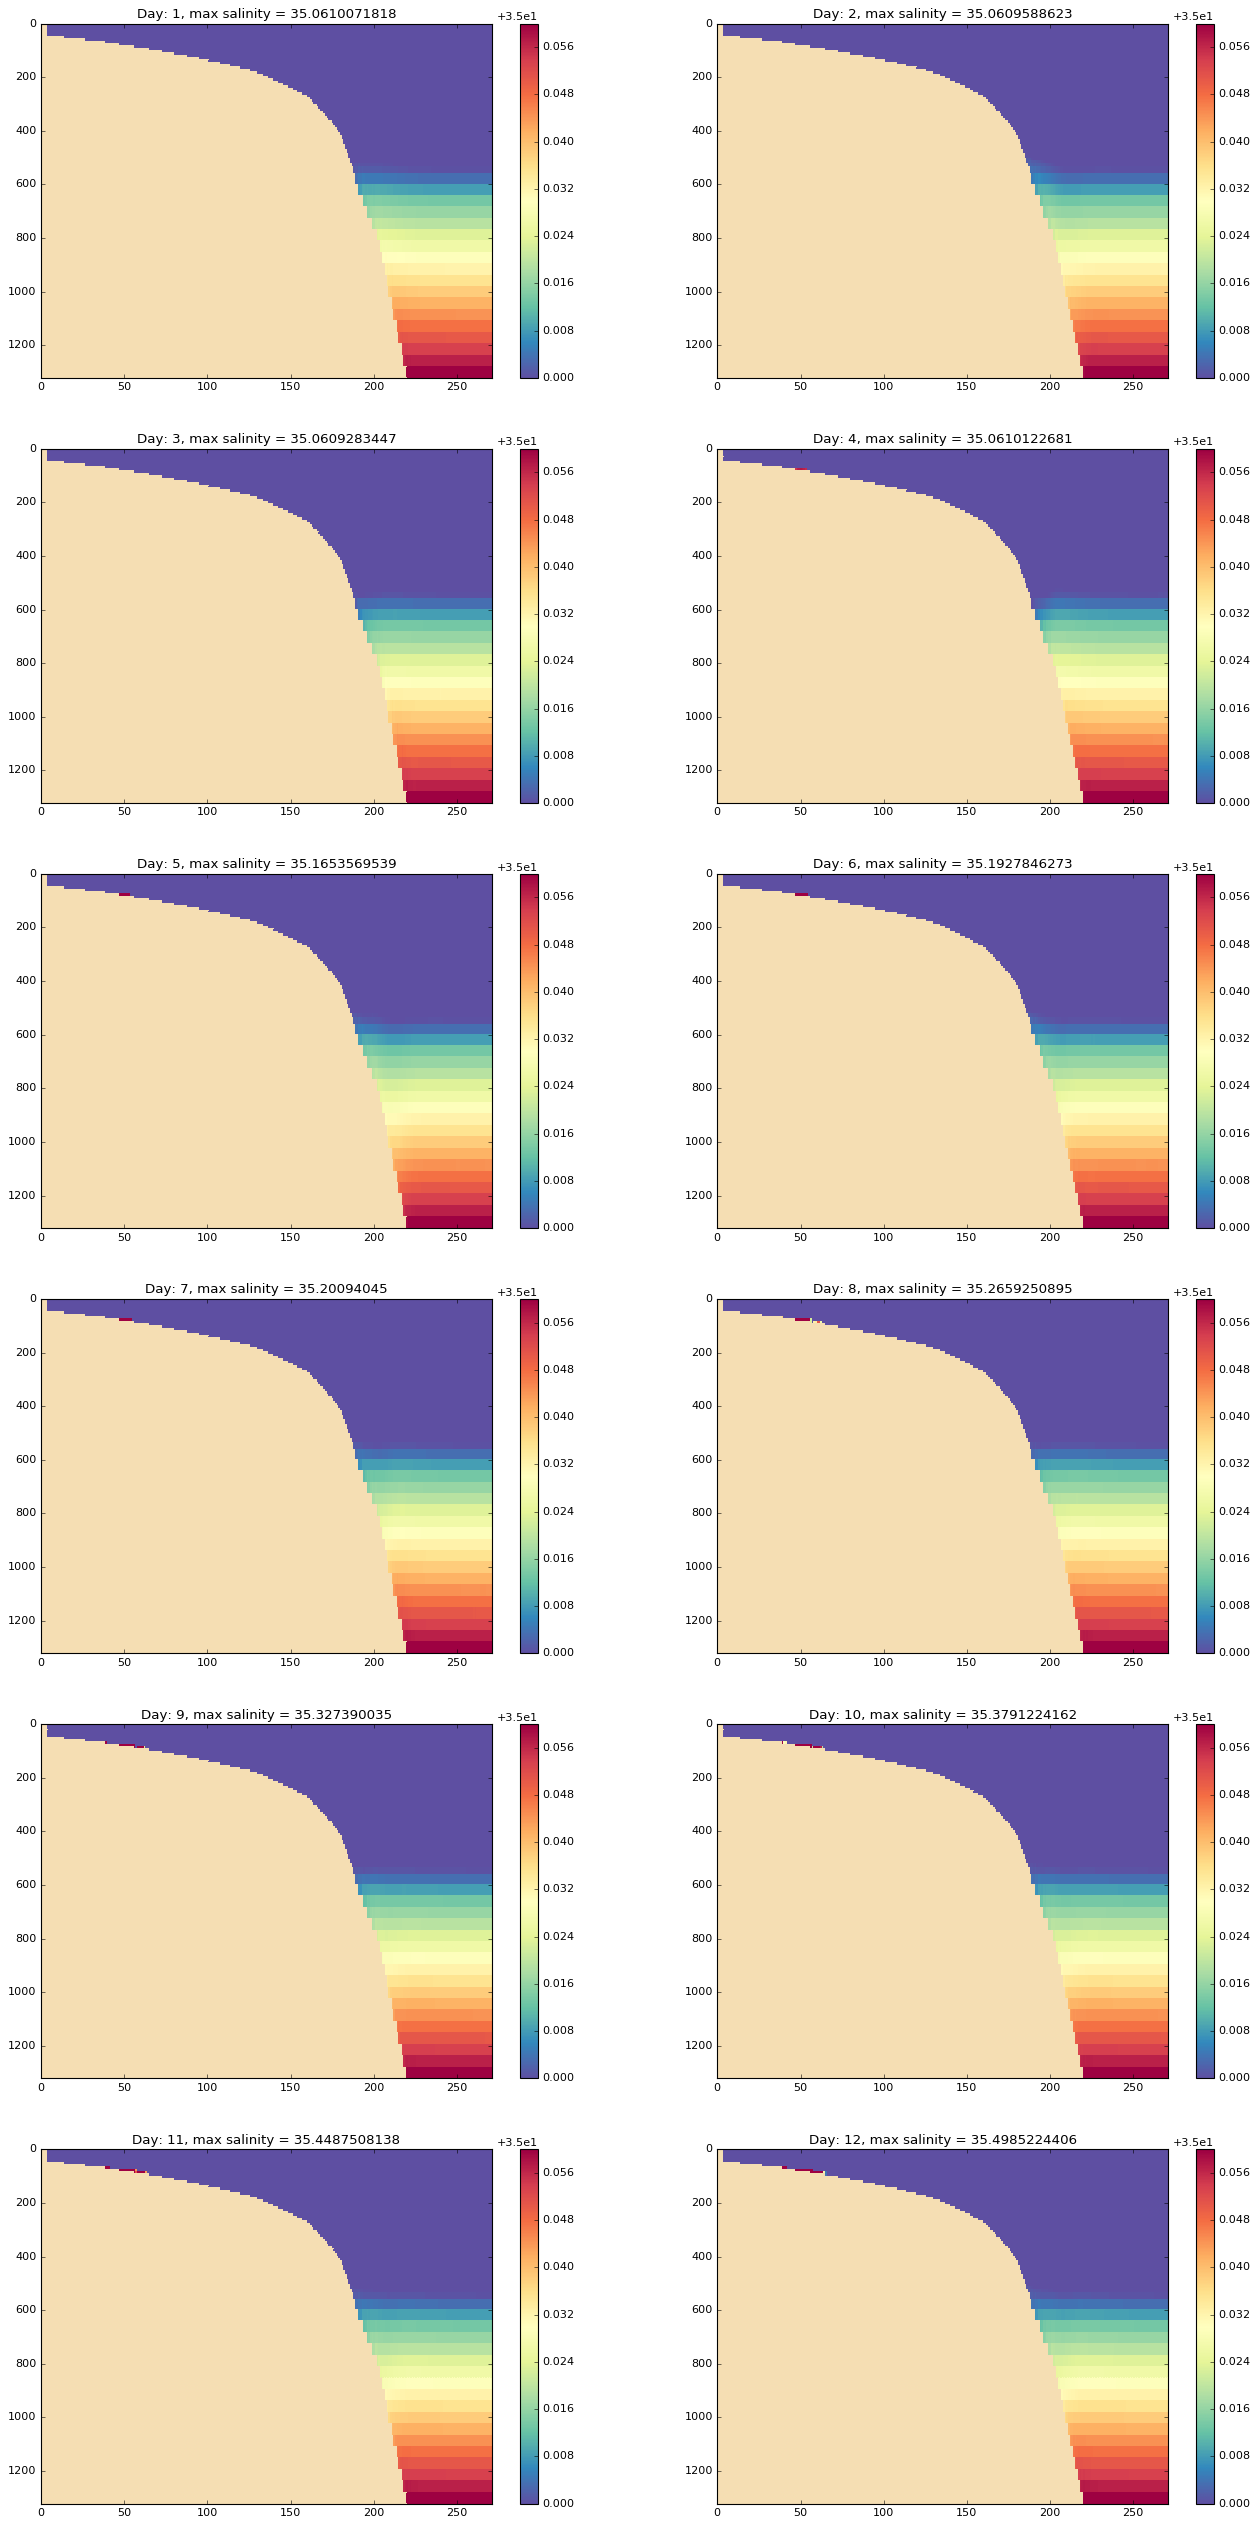

In [115]:
fig = plot_iso(vosaline_daily_ma, deptht, 35.0, 35.06, None, None)

# Ideal_double

In [121]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_double_flt/'
vosaline, tmask, deptht = get_vars_cross(dirname, x_ind)

vosaline_daily = np.full((vosaline.shape[-3]/24, vosaline.shape[-2], vosaline.shape[-1]), np.nan)

for i in range(vosaline_daily.shape[0]):
    day_start, day_end = i, i+1
    vosaline_daily[i, :, :] = get_1day_avg(vosaline, day_start, day_end)

tmask_cross = np.tile(tmask[0, 0, :, :], (vosaline_daily.shape[0], 1, 1))

vosaline_daily_ma = np.ma.array(vosaline_daily, mask = 1 - tmask_cross)

23.8398488363 36.7812245687


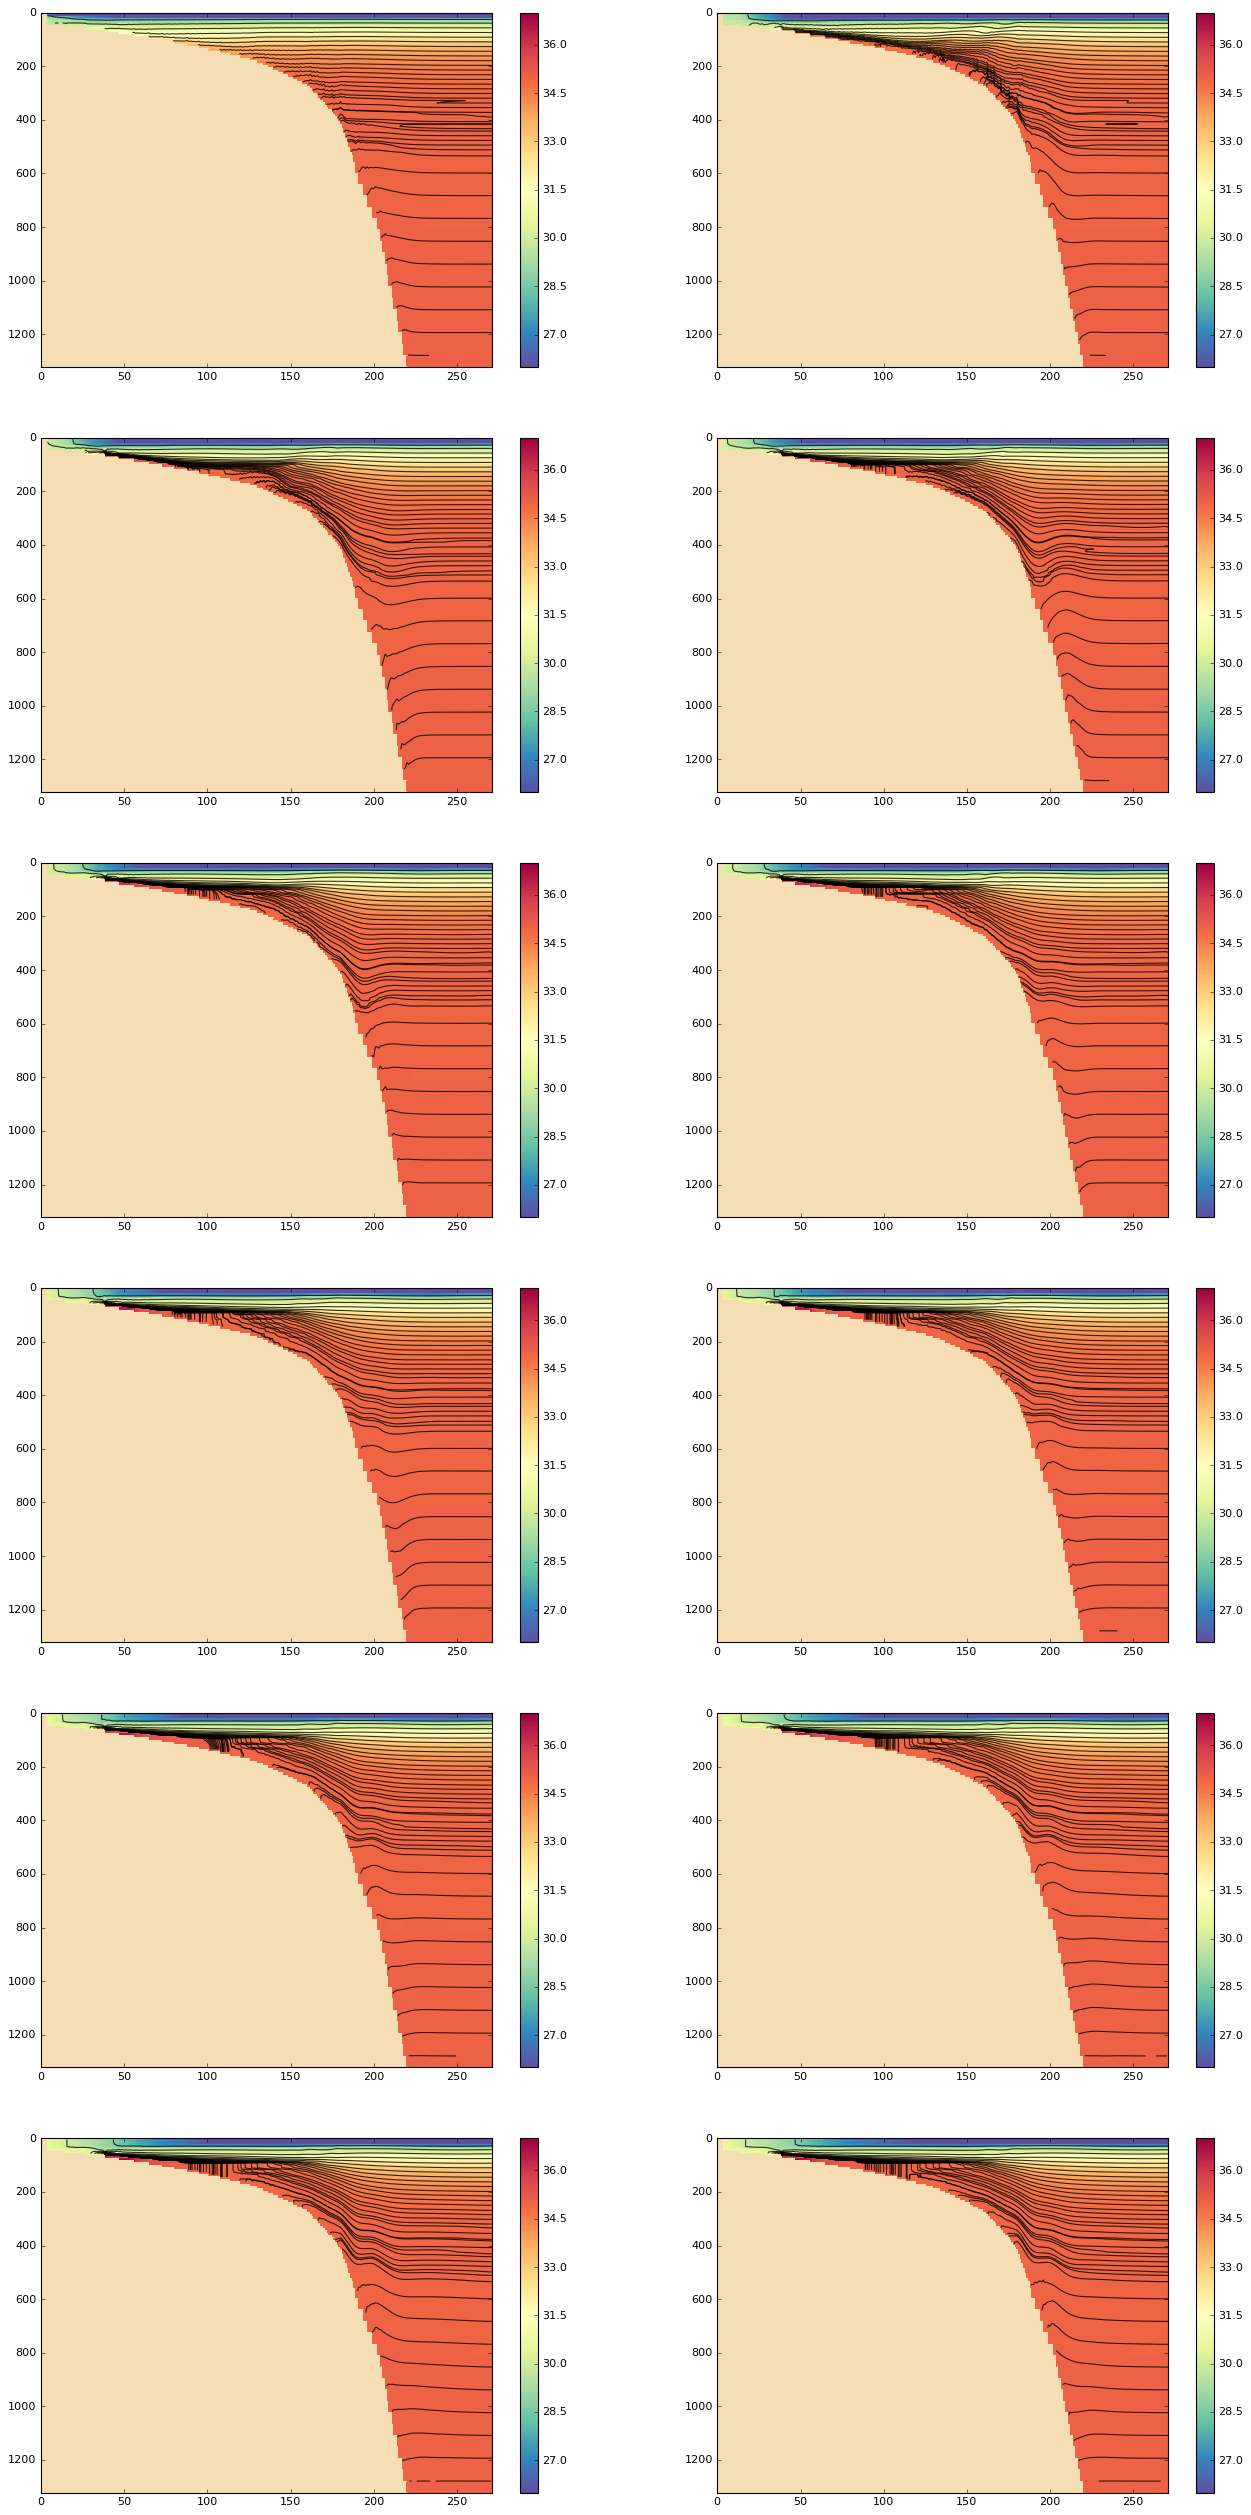

In [122]:
print(vosaline_daily_ma.min(), vosaline_daily_ma.max())

fig = plot_iso(vosaline_daily_ma, deptht, 26, 35.1, levels)

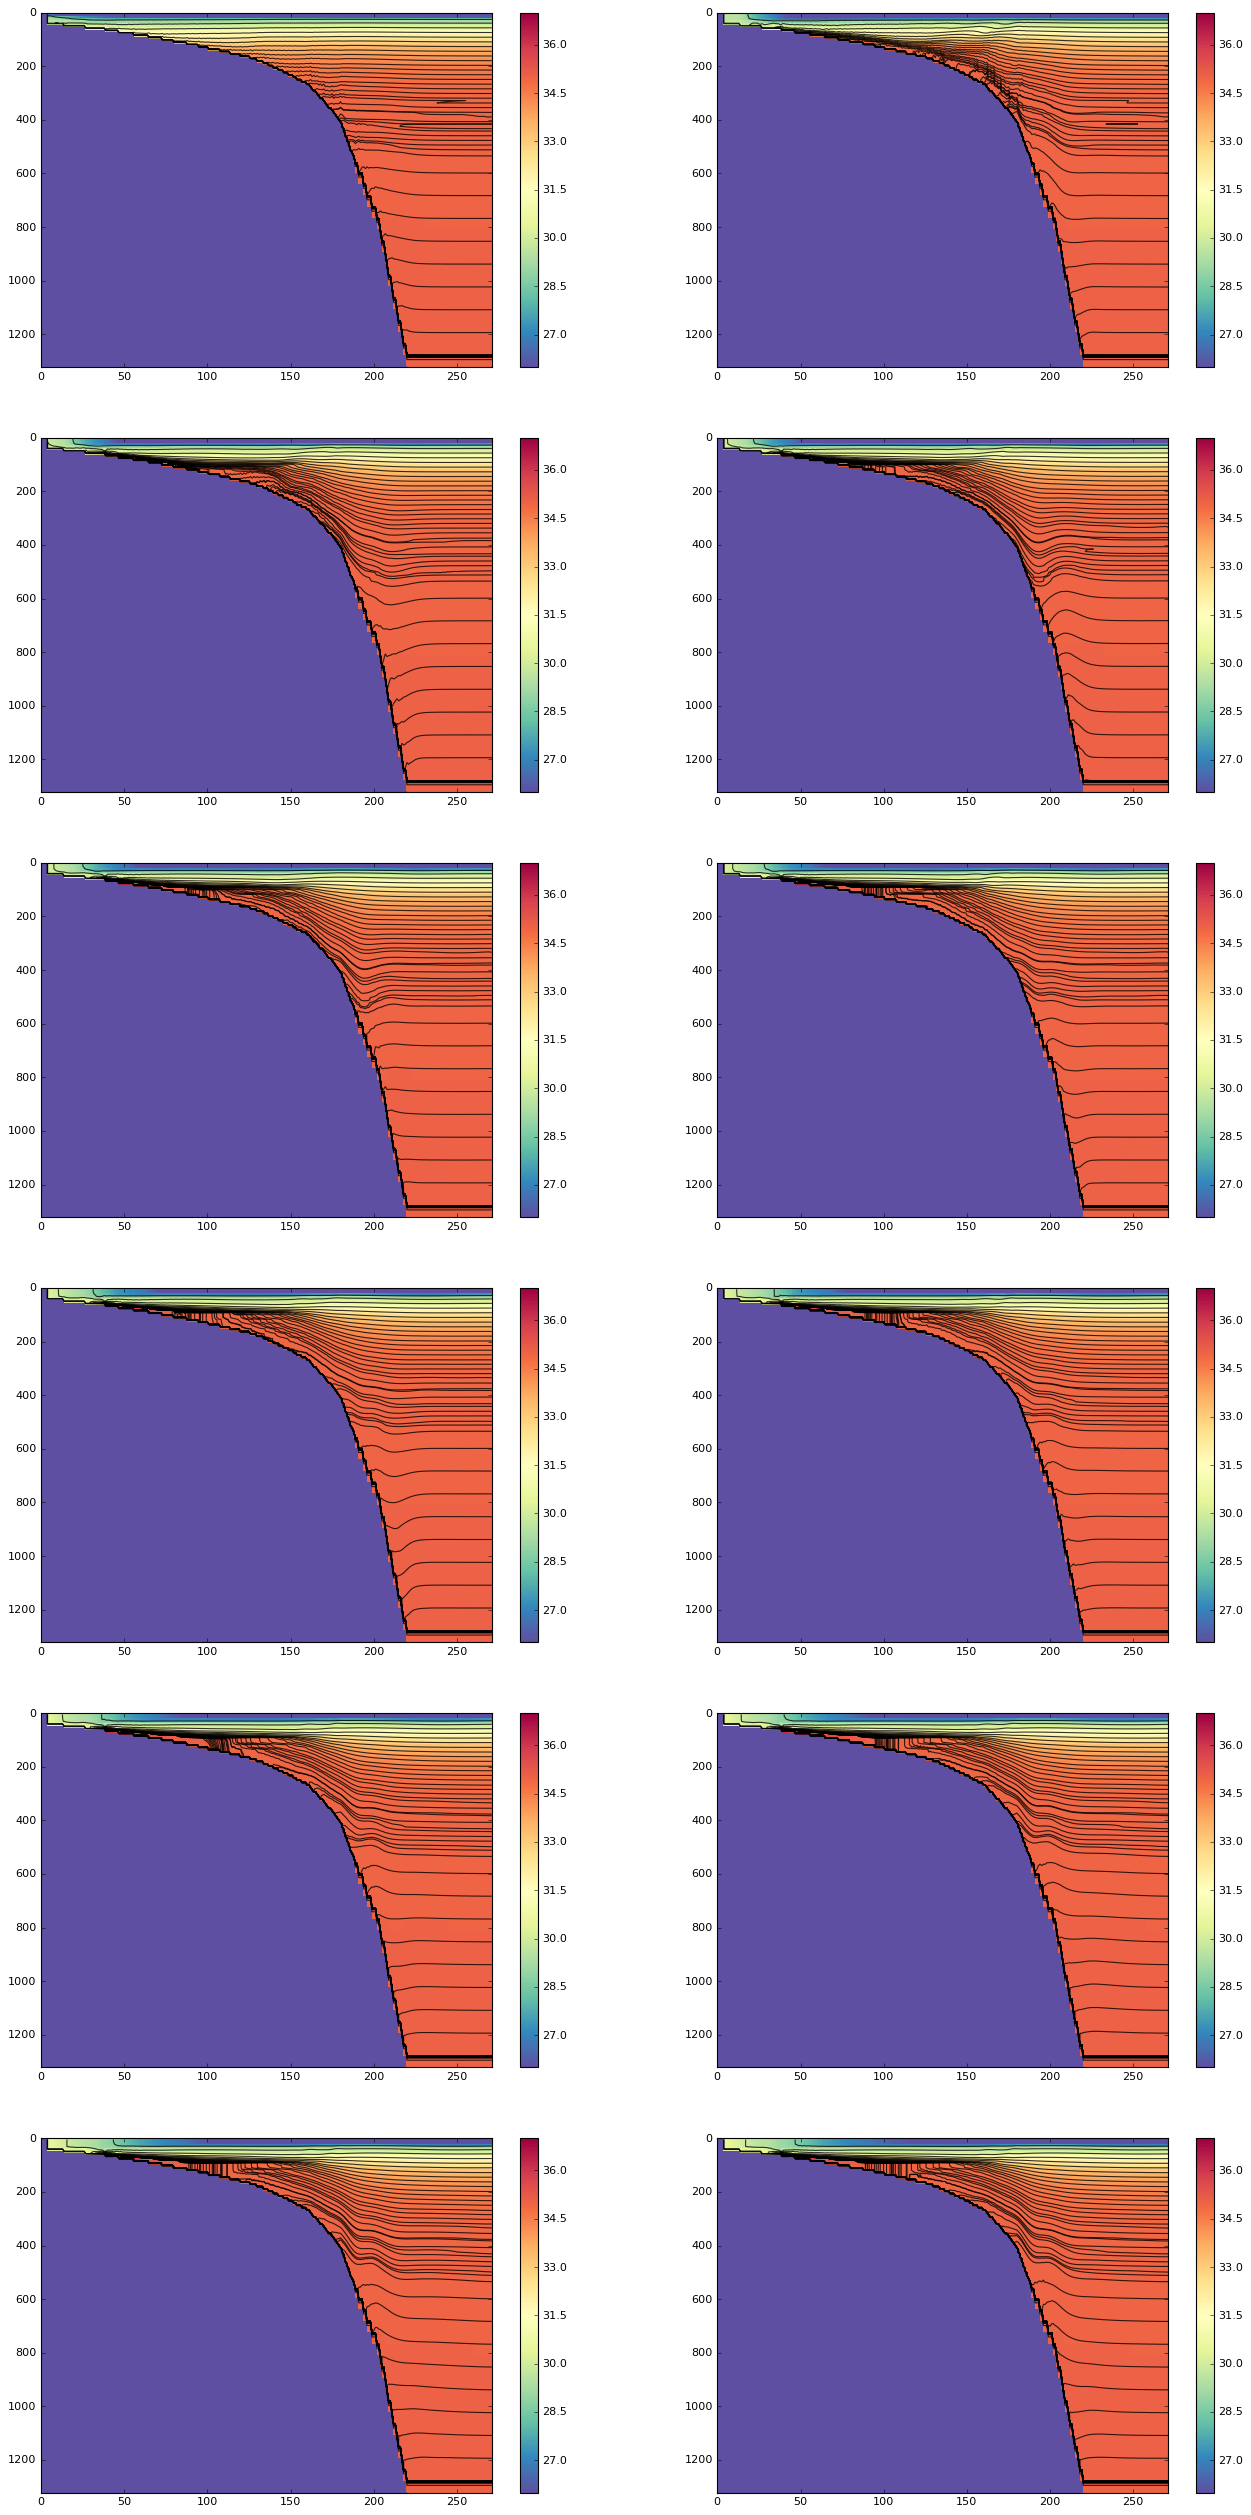

In [123]:
fig = plot_iso(vosaline_daily, deptht, 26, 35.1, levels)